/tmp/ipykernel_270/1220460368.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


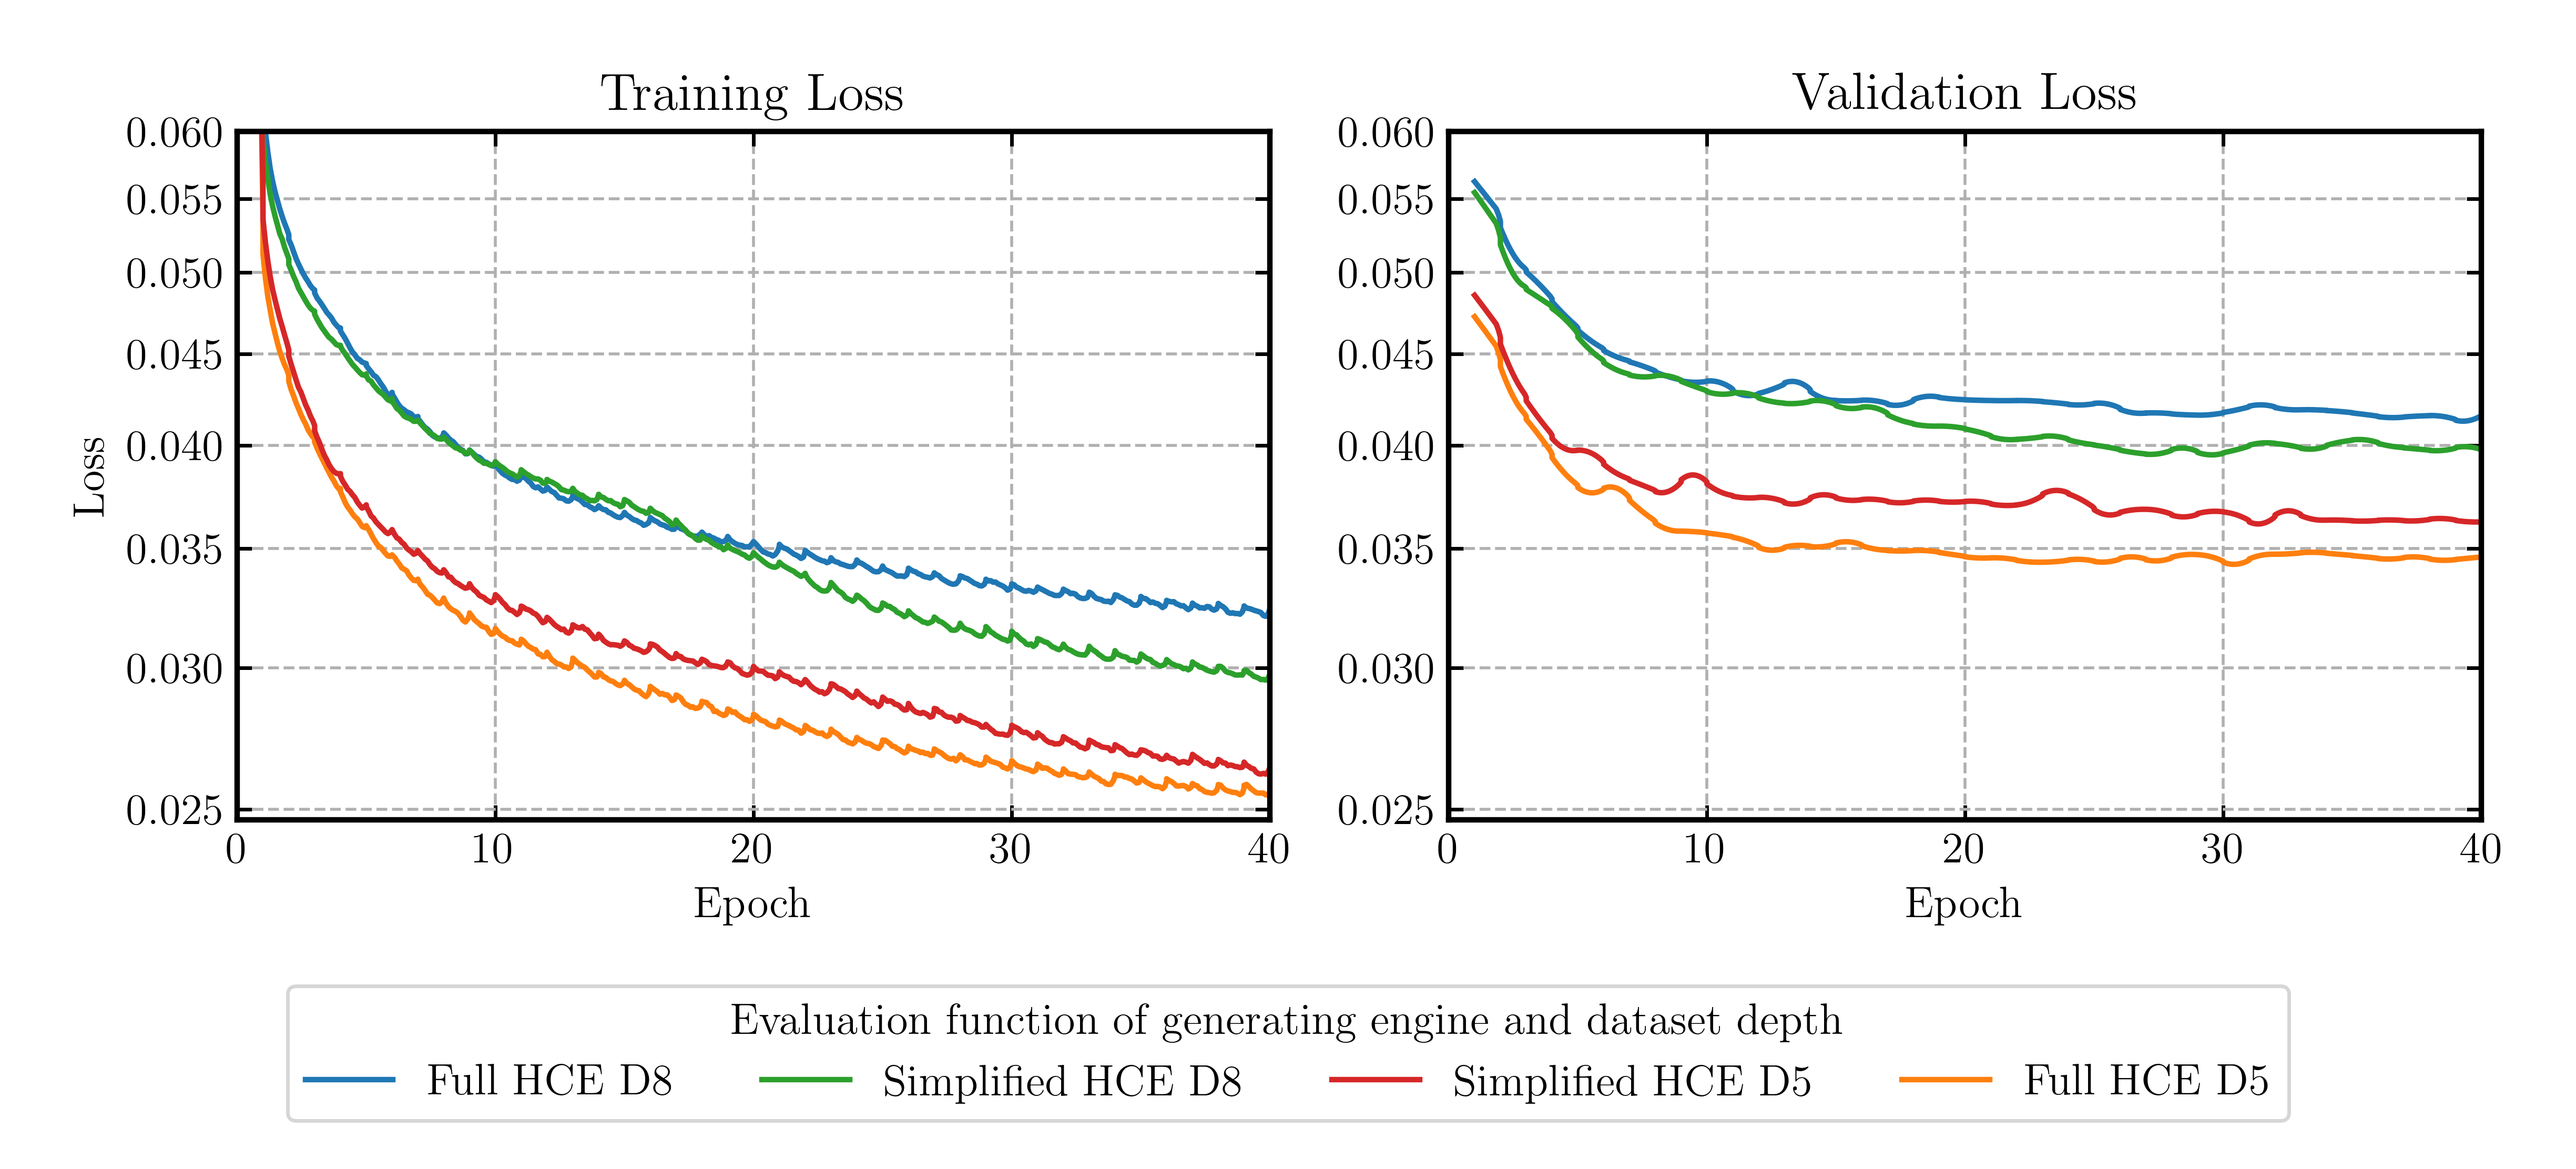

In [1]:
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "mathptmx",
    "font.size": 12
})

def transform_scalar_data(step_a, value_a, step_b, value_b):
    step = sorted(set(step_a + step_b))
    value_a_new = []
    value_b_new = []

    # Transform into single series
    for s in step:
        if s in step_a:
            index_a = step_a.index(s)
            value_a_new.append(value_a[index_a])
        else:
            value_a_new.append(None)

        if s in step_b:
            index_b = step_b.index(s)
            value_b_new.append(value_b[index_b])
        else:
            value_b_new.append(None)

    # interpolate missing values linearly
    for arr in [value_a_new, value_b_new]:
        prev_idx = -1
        for i in range(len(arr)):
            if arr[i] is not None:
                if prev_idx != -1:
                    delta = (arr[i] - arr[prev_idx]) / (i - prev_idx)
                    for j in range(i - 1, prev_idx, -1):
                        arr[j] = arr[prev_idx] + delta * (j - prev_idx)
                prev_idx = i

    return step, value_a_new, value_b_new

test = 0
def extract_scalar_data(event_file, run_name):
    global test
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    scalar_data = {}
    for tag in event_acc.Tags()['scalars']:
        scalar_events = event_acc.Scalars(tag)
        steps = [event.step for event in scalar_events]
        values = [event.value for event in scalar_events]

        if event_file.split("/")[-1] == "simple_d8_final_lr00085_sf55_adam":
            _steps = []
            _values = []
            for i in range(len(scalar_events)):
                if scalar_events[i].wall_time >= 1684064147:
                    _steps.append(steps[i])
                    _values.append(values[i])
            steps = _steps
            values = _values

        scalar_data[tag] = {'step': steps, 'value': values}

    steps, train_loss, val_loss = transform_scalar_data(
        scalar_data["training loss"]["step"],
        scalar_data["training loss"]["value"],
        scalar_data["validation loss"]["step"],
        scalar_data["validation loss"]["value"],
    )
    test = scalar_data

    return pd.DataFrame({"step": steps, "train_loss": train_loss, "validation_loss" : val_loss, "run_name": run_name}), len(scalar_data["validation loss"]["value"])

def plot_losses(df, window=5, log_scale=False):
    # Filter out steps with NaN validation loss
    df_filtered = df

    # Find changes in validation loss
    validation_loss_changes = df_filtered['validation_loss'].diff()

    # Find the indices where validation loss changes
    epoch_indices = validation_loss_changes[validation_loss_changes != 0].index

    # Compute steps per epoch
    steps_per_epoch = len(df) / epoch_indices.shape[0] * 500

    # Convert steps to epochs
    epochs = df_filtered['step'] / steps_per_epoch

    # Apply rolling average for smoothing
    train_loss_smooth = df_filtered['train_loss'].rolling(window=window, min_periods=1).mean()
    validation_loss_smooth = df_filtered['validation_loss'].rolling(window=window, min_periods=1).mean()

    # Plot the smoothed train_loss and validation_loss
    if log_scale:
        plt.semilogy(epochs, train_loss_smooth, label=f'Smoothed Train Loss ({df_filtered["run_name"].iloc[0]})')
        plt.semilogy(epochs, validation_loss_smooth, label=f'Smoothed Validation Loss ({df_filtered["run_name"].iloc[0]})')
    else:
        plt.plot(epochs, train_loss_smooth, label=f'Smoothed Train Loss ({df_filtered["run_name"].iloc[0]})')
        plt.plot(epochs, validation_loss_smooth, label=f'Smoothed Validation Loss ({df_filtered["run_name"].iloc[0]})')

def plot_multiple_runs(run_dict, window=5, log_scale=False, ylim=[None, None], max_epochs=25, tick_spacing = 0.01, tick_format = ":.2f", scale = 1.7, dpi = 800, legend_title = None):
    num_runs = len(run_dict)
    fig, axs = plt.subplots(1, 2, figsize=(8 * scale, 3 * scale), sharey=False, dpi=dpi)
    
    lines = []
    final_losses_val = []
    min_loss = 100

    for (run_name, event_file) in run_dict.items():
        df, num_epochs = extract_scalar_data(event_file, run_name)

        df_filtered = df
        steps_per_epoch = df["step"].tolist()[-1] / num_epochs

        df_filtered = df_filtered[df_filtered["step"] / steps_per_epoch <= max_epochs]
        epochs = df_filtered['step'] / steps_per_epoch
        train_loss_smooth = df_filtered['train_loss'].rolling(window=window, min_periods=1).mean()
        validation_loss_smooth = df_filtered['validation_loss'].rolling(window=window, min_periods=1).mean()

        if log_scale:
            line_train, = axs[0].semilogy(epochs, train_loss_smooth, label=run_name, base=10)
            line_val, = axs[1].semilogy(epochs, validation_loss_smooth, label=run_name, base=10)
        else:
            line_train, = axs[0].plot(epochs, train_loss_smooth, label=run_name)
            line_val, = axs[1].plot(epochs, validation_loss_smooth, label=run_name)

        lines.append(line_val)
        final_losses_val.append(validation_loss_smooth.iloc[-1])
        min_loss = min(min_loss, validation_loss_smooth.iloc[-1])
        min_loss = min(min_loss, train_loss_smooth.iloc[-1])

    # Sort by final validation losses
    sorted_lines_and_labels = sorted(zip(final_losses_val, lines), key=lambda x: x[0], reverse=True)

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')

    axs[1].set_xlabel('Epoch')
    axs[1].set_title('Validation Loss')
   

    for i in [0, 1]:
        axs[i].tick_params(axis='x', direction='in', length=4, width=1, top=True)
        axs[i].tick_params(axis='y', direction='in', length=4, width=1, right=True)
        axs[i].minorticks_off()
        axs[i].grid(True, linestyle='--')

        ticks = [i * tick_spacing for i in range(100)]
        axs[i].set_yticks(ticks)
        axs[i].set_yticklabels(["$"+tick_format.format(i)+"$" for i in ticks])
        axs[i].set_xlim([0, max_epochs])


        for axis in ['top', 'bottom', 'left', 'right']:
            axs[i].spines[axis].set_linewidth(1.5)  # change width

        if ylim[0] is None:
            ylim[0] = min_loss - 0.001
        axs[i].set_ylim(ylim)

    
    # Adding the legend
    fig.subplots_adjust(bottom=0.2)
    # legend_ax = fig.add_axes([1, 0.82, 0, 0])
    legend_down = 0.18
    legend_ax = fig.add_axes([0, -legend_down, 1, 1 + legend_down])
    legend_ax.axis('off')
    legend_ax.legend([line for _, line in sorted_lines_and_labels],
                     [line.get_label() for _, line in sorted_lines_and_labels],
                     loc='lower center', ncol=10, title=legend_title)

    plt.tight_layout()
    plt.show()




run_dict = {
    # 0.05
    # "0.25M": '/home/jeff/bakalauras/runs/full_d8_250k_lr00085_sf55_adam',
    # "0.5M": '/home/jeff/bakalauras/runs/full_d8_500k_lr00085_sf55_adam',
    # "1M": '/home/jeff/bakalauras/runs/full_d8_1000k_lr00085_sf55_adam',
    # "2M": '/home/jeff/bakalauras/runs/full_d8_2000k_lr00085_sf55_adam',
    # "2.8M": '/home/jeff/bakalauras/runs/full_d8_nocap_lr00085_sf55_adam',

    # # 0.09
    # "Remove all": '/home/jeff/bakalauras/runs/full_d8_m0_norm_lr00085_sf55_adam',
    # "Mate depth $\le$ 2": '/home/jeff/bakalauras/runs/full_d8_m2_norm_lr00085_sf55_adam',
    # "Mate depth $\le$ 4": '/home/jeff/bakalauras/runs/full_d8_m4_norm_lr00085_sf55_adam',
    # "Mate depth $\le$ 6": '/home/jeff/bakalauras/runs/full_d8_m6_norm_lr00085_sf55_adam',
    # "Keep all": '/home/jeff/bakalauras/runs/full_d8_ma_norm_lr00085_sf55_adam',

    # 0.06
    "Full HCE D8": '/home/jeff/bakalauras/runs/full_d8_final_lr00085_sf55_adam',
    "Full HCE D5": '/home/jeff/bakalauras/runs/full_d5_final_lr00085_sf55_adam',
    "Simplified HCE D8": '/home/jeff/bakalauras/runs/simple_d8_final_lr00085_sf55_adam',
    "Simplified HCE D5": '/home/jeff/bakalauras/runs/simple_d5_final_lr00085_sf55_adam',
}
plot_multiple_runs(run_dict, log_scale=True,  ylim=[None, 0.06], window=10, max_epochs=40, tick_spacing = 0.005, tick_format = "{:.3f}", scale=1.2, dpi = 500, legend_title="Evaluation function of generating engine and dataset depth")